In [ ]:
import sqlite3
from typing import TypedDict, Annotated
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage, RemoveMessage
from langgraph.graph.message import add_messages
from langchain_deepseek import ChatDeepSeek
from langgraph.graph import END, START, StateGraph


conn = sqlite3.connect("langchain.db", check_same_thread=False)
memory = SqliteSaver(conn=conn)

class State(TypedDict):
    messages: Annotated[BaseMessage, add_messages]
    summary: str

model = ChatDeepSeek(model="deepseek-chat", api_key="sk-1c53e019ded846deaf29cb87c56689a2")

def summarize_conversation(state: State)->State:

    summary = state.get("summary")
    
    if summary:
        sys_msg = f"""Given this conversation summary: {summary}

        Your task:
        1. Analyze new messages provided above
        2. Identify key updates in topic, context, or user intent
        3. Integrate these updates with existing summary
        4. Maintain chronological flow and contextual relevance
        5. Focus on information essential for conversation continuity

        Generate an updated summary that maintains clarity and coherence."""
                
    else:
        sys_msg = """Analyze the conversation above and create a concise summary that:
        1. Captures main topics and key points discussed
        2. Preserves essential context and decisions made
        3. Notes any unresolved questions or action items
        4. Maintains chronological order of major developments

        Focus on information needed for conversation continuity."""

    messages = state["messages"] + [HumanMessage(content=sys_msg)]
    response = model.invoke(messages)
    deleted_messages = [RemoveMessage(m.id) for m in state["messages"][-2]] 
    return {"messages": deleted_messages, "summary": response.content}

def conversation(state: State)->State:
    summary = state.get("summary")
    if summary:
        sys_msg = f"Summary of previous conversation with the user: {summary}"
        messages = [SystemMessage(sys_msg)] + state["messages"]
    else:
        messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": response}

def should_continue(state: State) -> str:
    """Return to the next node to execute"""
    messages = state.get("messages")
    if len(messages) > 4:
        return "summarize_conversation"
    return "END"

builder = StateGraph(State)
builder.add_node("conversation", conversation)
builder.add_node("summarize_conversation", summarize_conversation)
builder.add_edge(START, "conversation")
builder.add_conditional_edges(
    "conversation", 
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        END: END
    }
)
builder.add_edge("summarize_conversation", END)
graph = builder.compile(checkpointer=memory)
    

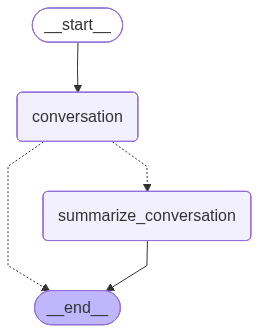

In [6]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
config = {"configurable": {"thread_id": 1}}
h_message = HumanMessage(content="Hello, I am Tim, how are you ?")
response = graph.invoke({"messages": [h_message]}, config=config)
# for r in response["messages"]:
#     r.pretty_print()

KeyError: 'END'